In [2]:
# ! pip install dask

In [1]:
import dask.dataframe as dd
import json
import os
import ijson
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
folder_list = ["top", "popular", "esoteric", "diverse"]
entries_to_take = 1000  # the number of entries to take based on requirements and computational resources

# initialize an empty DataFrame
subset_df = pd.DataFrame()

# loop through the folders and years to create a combined subset
for folder in folder_list:
    for year in range(2000, 2024):
        file_path = os.path.join(folder, f"{year}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                # extract the top 1000 entries from the JSON file using ijson
                entries = []
                for i, entry in enumerate(ijson.items(file, 'item')):
                    if i >= entries_to_take:
                        break
                    entry['chart_type'] = folder
                    entries.append(entry)

                # create a DataFrame from the extracted entries and concatenate it to the subset_df
                temp_df = pd.DataFrame(entries)
                subset_df = pd.concat([subset_df, temp_df])

# reset index for the final subset DataFrame
subset_df.reset_index(drop=True, inplace=True)

In [3]:
subset_df = subset_df[['lyrics']]

In [4]:
# from Pandas dataframe to Dask dataframe
df = dd.from_pandas(subset_df, npartitions=5)


#### Note that in this approach, the word frequencies are calculated using Dask's lazy evaluation. The computation is performed when calling compute() on the resulting Dask Series, which triggers the actual execution of the task graph.

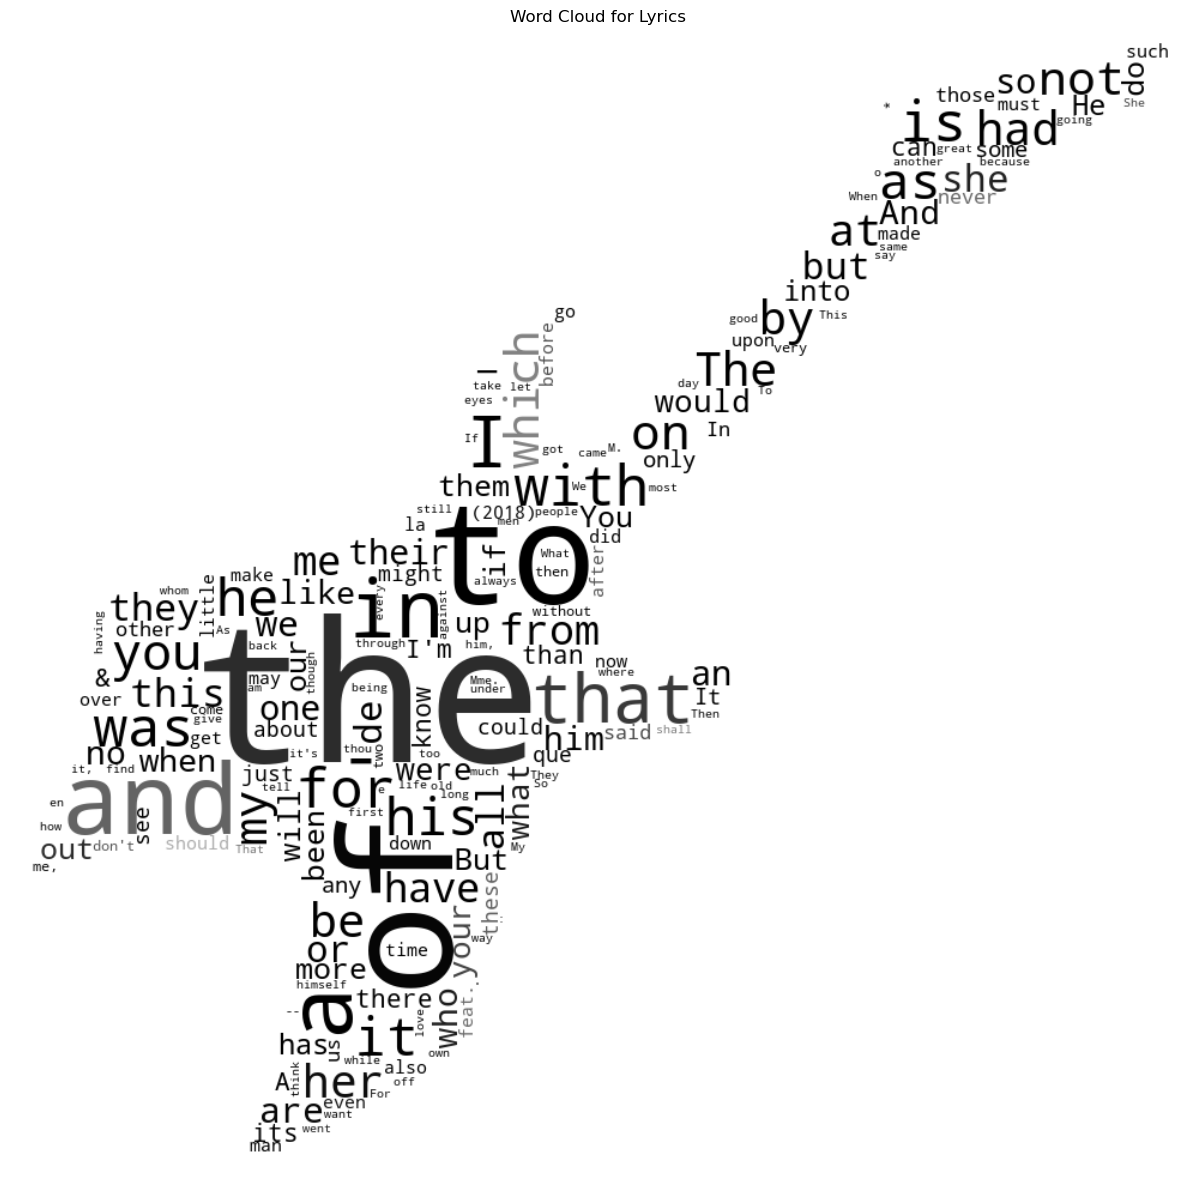

In [9]:
# preprocess the data
df['lyrics'] = df['lyrics'].str.replace('\n', ' ')

# compute the word frequencies
word_frequencies = df['lyrics'].str.split().explode().value_counts().compute()

# load custom guitar mask image
guitar_mask = np.array(Image.open("guitar.png"))

# generate the word cloud
wordcloud = WordCloud(background_color='white', mask=guitar_mask)

# generate the word cloud from frequencies
wordcloud.generate_from_frequencies(word_frequencies)

# create a color map from the guitar mask image
image_colors = ImageColorGenerator(guitar_mask)

# plot the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Lyrics')
plt.show()
